In [1]:
#JUST LOSS, NO CYCLING NEXT

# Need to check what happens to the mantle temperature when cycling + atmospheric loss is turned off.
#XXX Mantle temp should be coupled and self-consistent.
# If it looks the same as the cycling + loss simulations, something is wrong with the definition in the code. XXX

# NOTE!!!!
## (np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref)))) in place of (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref)))) in many places of Tad's code (i.e., f_wtwid not being calculated correctly) --> This is fixed in my recoded version

In [2]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Cycling and atmospheric loss switches. -- MUST BE INITIALIZED HERE, OR CODE WON'T RUN.
# 0. = OFF, 1. = ON

atmos_loss = 0. #0., 1. 
cycling = 1. #0., 1.

In [4]:
M_E = 5.972e24
R_E = 6.371e6
x_h = 0.05
rho_c = 3.e3
chi = 0.23
d_hE = 3e3
rho_m = 3.3e3
d_melt = 60.e3
f_degasE = 0.9
G = 6.67e-11
P_E = 4.e7
f_M = 0.68
f_b = 0.9
omega_0 = 2.3e-4
f_btwid = 1.3
year = 3.154e+7
omg_Etwid = 6.2e-4/2.3e-4 # from CA2014: omega/omega_0

In [5]:
#print 5.8e-4*f_M/(omega_0*f_btwid)

In [6]:
gamma = rho_m*d_melt*f_degasE*omega_0*f_btwid/(x_h*rho_c*chi*d_hE*f_M)
tau = M_E*omega_0*f_btwid/(1.5*2.*math.pi*R_E*0.1/year*x_h*rho_c*chi*d_hE)
#print tau/(1.e9*year)

### Convection scheme (standard boundary-layer, no core)

In [7]:
E_a = 335.e3
R_g = 8.314
alpha = 2.e-5
Ra_c = 1100.
kappa = 1.e-6
T_ref = 1600.
#eta_0 = 1.e21
#eta_0 = 1.e16
k = 4.2
beta = 0.3
c_p = 1200.
Q_0 = 5.e-8
year = 3.154e+7

In [8]:
def Rp(M):
    return R_E*(M/M_E)**(0.27)
def Rc(M): 
    return .547*R_E*(M/M_E)**(0.247)
def h(M):
    return Rp(M)-Rc(M)
def V(M):
    return 4./3.*math.pi*(Rp(M)**3. - Rc(M)**3.)
def A(M):
    return 4.*math.pi*Rp(M)**2.
def rho_av(M):
    return (M-(0.3259*M))/V(M)
def g(M):
    return G*M/(Rp(M)**2.)
def gtwid(M):
    return g(M)/9.8

In [9]:
print(Rp(M_E))

6371000.0


In [10]:
C0 = -7.9859
C1 = 4.3559
C2 = -0.5742
C3 = 0.0337
f_M = 0.68
f_btwid = 1.3
omega_0 = 2.3e-4
M_oliv = 153.31
M_wat = 18.01528
x_fact = (omega_0*f_btwid)/f_M
B = M_oliv/M_wat*x_fact
def lnfugacity(x,temp):
    y = np.log(2.e6*x*B/(1.-(x*B)))
    return C0 + C1*y + C2*y**2 + C3*y**3
#nonlinear eta
r_fug=1.
eta_scale = (np.exp(lnfugacity(1,T_ref)))**(-r_fug)
eta_0 = 1.e21/eta_scale
#eta_0 = 1.e21
print(eta_0)
#print eta_scale

9.034775470293381e+24


In [11]:
#other eta param -- CYCLES ALL WATER OUT OF MANTLE, DOESN'T GO BACK IN --
# NOT IN TAD'S CODE FOR PAPER, SO COMMENTED OUT
#C0 = -7.9859
#C1 = 4.3559
#C2 = -0.5742
#C3 = 0.0337
#f_M = 0.68
#f_btwid = 1.3
#omega_0 = 2.3e-4
#M_oliv = 153.31
#M_wat = 18.01528
#A_w = 26.
#E_w = 40.e3
#x_fact = (omega_0*f_btwid)/f_M
#B = M_oliv/M_wat*x_fact
#def lnfugacity(x,temp):
#    C = x*B/(1.-(x*B))
#    return np.log(C/A_w*np.exp(E_w/(R_g*T_ref*temp)))
#    #y = np.log(2.e6*x*B/(1.-(x*B)))
#    #return C0 + C1*y + C2*y**2 + C3*y**3
##nonlinear eta
#r=1.
#eta_scale = (np.exp(lnfugacity(1.,T_ref)))**(-r)
#eta_0 = 1.e21/eta_scale
##eta_0 = 1.e21
##print eta_0
##print eta_scale

In [12]:
# Calculate the mantle viscosity, to be plotted for comparison.
# It is parameterized as "eta" in Komacek & Abbot (2016).

def eta(x_twid, T_twid): #x and T are non-dimensionalized later in code -- need to add dimensions back for these calculations
    E_a = 335.0e3
    R_g = R_g = 8.314
    r_fug = 1.
    eta_scale = (np.exp(lnfugacity(1.,T_ref)))**(-r_fug)
    eta_0 = 1.e21/eta_scale
    
    
    x = x_twid * 2.3e-4 * 1.3 / 0.68 # mantle water mass fraction
    T = T_twid * 1600 #[K]
    
    y = np.exp(lnfugacity(x, T))
    
    return eta_0 * (y**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))

In [13]:
print(eta(1.32, 1.))

1.3717129498740124e+26


In [14]:
# Atmospheric loss ON/OFF -- now with a switch!

def f_omegatwid(x_twid, M, t):
    if atmos_loss == 0.:
        return omg_Etwid/(f_btwid)
    
    else:
        # Calculate mass of water in mantle, total mass of water
        M_w_mantle = x_twid * 2.3e-4 * 1.3 * M
        M_w_i = (omg_Etwid/f_btwid) * 2.3e-4 * 1.3 * M
    
        # Calculate water on surface, and remove a small amount.
        M_w_surf = (M_w_i - M_w_mantle) - 1e19*t #1e19*t is safe -- roughly 1 TO lost over simulations
    
        # Recalculate omega after some water has been lost, and omegatwid (which is the function output).
        M_w_f = M_w_surf + M_w_mantle
   
        return (M_w_f / M) / (2.3e-4 * 1.3)

In [15]:
def tau_1_inv(M): #1/tau = 1/tau_CA in paper
    return M*omega_0*f_btwid/(1.5*2.*math.pi*R_E*0.1/year*x_h*rho_c*chi*d_hE)
def omega(M): #F_0 in paper
    return k*T_ref**(1.+beta)*A(M)/(h(M)*V(M))*(alpha*rho_m*g(M)*h(M)**3.*np.exp(lnfugacity(1,T_ref))/(Ra_c*kappa*eta_0))**(beta)
def tau_2_inv(M):
    return rho_m*c_p*T_ref/omega(M)
def Q_0twid(M):
    return Q_0/omega(M)
def taudecaytwid(M):
    return 2.e9*year/tau_2_inv(M)
def Qtwid(t,M):
    return math.exp(-t/taudecaytwid(M))
T_s = 280.
T_stwid = T_s/T_ref
T_mtwid = T_ref*R_g/(E_a)
#print tau_1_inv(M_E)/(3.156e7*1.e9)
#print tau_2_inv(M_E)/(3.156e7*1.e9)
def tau_2_inv_re(M):
    return rho_m*c_p*T_ref/Q_0
#print tau_2_inv_re(M_E)/(3.156e7*1.e9)

In [16]:
t = 0.
print(math.exp(-t/(2.e9*year/(rho_m*c_p*T_ref/omega(M_E)))))
print(Q_0twid(M_E)*Qtwid(t,M_E))
print(omega(M_E)/5e-8)

1.0
1.8830689892047734
0.5310479890714485


In [17]:
print(tau_1_inv(M_E)/year/1e9)
print(tau_2_inv(M_E)/year)
x = 1.035
temp = 2.
t = 0.
#print(tau_1_inv(M_E)/tau_2_inv(M_E)*Q_0twid(M)*Qtwid(t,M))
#print(tau_1_inv(M_E)/tau_2_inv(M_E)*((np.exp(lnfugacity(x,temp))/np.exp(lnfugacity(1,T_ref)))**(beta)*(temp - T_stwid)**(beta+1.)*math.exp(-beta/T_mtwid*((1./temp) - 1.))))

2.8732400081113805
7565710282.562742


In [18]:
def f_conv_water(t,temp,x,M):
    return Q_0twid(M)*Qtwid(t,M) - ((np.exp(lnfugacity(x,temp))/np.exp(lnfugacity(1,T_ref)))**(beta)*(temp - T_stwid)**(beta+1.)*math.exp(-beta/T_mtwid*((1./temp) - 1.)))

In [19]:
print(Q_0twid(M_E)*Qtwid(0.,M_E))

1.8830689892047734


In [20]:
print(tau_1_inv(M_E)/tau_2_inv(M_E)*f_conv_water(0.,2.,1.035,M_E)*1e-5)
print(tau_1_inv(M_E)/tau_2_inv(M_E)*Q_0twid(M_E)*Qtwid(0., M_E))
print(tau_1_inv(M_E)/tau_2_inv(M_E)*(np.exp(lnfugacity(1.035,2.))/np.exp(lnfugacity(1,T_ref)))**(beta)*(2. - T_stwid)**(beta+1.)*math.exp(-beta/T_mtwid*((1./2.) - 1.)))
#print(T_array_CA[0]-2.)

-0.00036394173013660174
0.715135652271409
37.10930866593158


NameError: name 'T_array_CA' is not defined

In [21]:
print(-0.000693219276325435/-0.0003641672839547194)

1.9035737334703298


### Water cycling scheme (from S+S)

In [22]:
#constants
K_cnst = 43.
gamma_cnst = 0.75
f_M = 0.68
theta_cnst = 1.5
Ktwid = K_cnst/T_ref
lambda_twid = Ktwid*(omega_0*f_btwid/f_M)**(gamma_cnst)
chi_r = 0.03
chi_d = 0.02
T_serp = 973.
#use more realistic values of liquidus and solidus later!!!
T_liq = 1225.+273.15
T_sol = 975.+273.15
T_liqtwid = T_liq/T_ref
T_soltwid = T_sol/T_ref
def L_MOR(M):
    return 1.5*2.*math.pi*Rp(M)

In [23]:
N = rho_m*d_melt*chi_d*omega_0*f_btwid/f_M*(T_liqtwid-T_soltwid)**(-theta_cnst) #Pi in paper
def Pi(M): #D in paper
    return x_h*rho_c*chi_r*h(M)**(1.-3.*beta)*(T_serp-T_s)/(T_ref**(1.+beta))*(kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*(np.exp(lnfugacity(1.,T_ref)))))**(beta)
def Ntwid(M): #Pitwid in paper
    return N/Pi(M)
def Sigma(M):
    return M*omega_0*f_btwid*h(M)**(1.-6.*beta)*kappa**(2.*beta-1)/(10.76*L_MOR(M))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*(np.exp(lnfugacity(1.,T_ref)))))**(2.*beta)
#def tau_4_inv(M): #Not actually used -- redefined later.
#    return Sigma(M)/Pi(M)
#print tau_4_inv(M_E)/(3.156e7*1.e9)

In [24]:
# Not actually used -- redefined below.

#def f_M_feed(t,temp,x,M): #water cycling OFF
#    
#    if cycling == 0.:
#        return 0.
#    
#    else:
#        return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1.,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - Ntwid(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1.,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)

In [25]:
#Not actually used -- redefined below.

#def f_all_wat_feed(t,z,M):
#    temp = z[0]
#    x = z[1]
#    return [tau_1_inv(M)/tau_2_inv(M)*f_conv_water(t,temp,x,M),tau_1_inv(M)/tau_4_inv(M)*f_M_feed(t,temp,x,M)]


### Now add hydrated layer depth check

In [26]:
N = rho_m*d_melt*chi_d*omega_0*f_btwid/f_M*(T_liqtwid-T_soltwid)**(-theta_cnst) #Pi in paper
def Pi(M): #D in paper
    return x_h*rho_c*chi_r*h(M)**(1.-3.*beta)*(T_serp-T_s)/(T_ref**(1.+beta))*(kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*(np.exp(lnfugacity(1.,T_ref)))))**(beta)
def Pitwid(M): #1/Pitwid in paper
    return Pi(M)/N #D/Pi in paper
def Sigma(M):
    return M*omega_0*f_btwid*h(M)**(1.-6.*beta)*kappa**(2.*beta-1)/(10.76*L_MOR(M))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*(np.exp(lnfugacity(1.,T_ref)))))**(2.*beta)
def tau_4_inv(M):
    return Sigma(M)/N #Sigma/Pi in paper
#print tau_4_inv(M_E)/(3.156e7*1.e9)

In [74]:
#print((tau_1_inv(M_E)/tau_2_inv(M_E))/(3.156e7*1.e9))
#print((Sigma(M_E)/Pi(M_E))/(3.156e7*1.e9))
print(N)
print(Pi(M_E))
print(Sigma(M_E))
print(1./Pitwid(M))

28192.099695026962
277731.95400914253
1.944439094682716e+22
0.10150830427707616


In [28]:
def Pi_2(M): #D2 in paper
    return h(M)**(1.-3.*beta)*(T_serp-T_s)/(T_ref**(1.+beta))*(kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*(np.exp(lnfugacity(1,T_ref)))))**(beta)
def Pi_2_1(t,temp,x,M): #D2_max*x_h*rho_c*chi_r in paper
    return x_h*rho_c*chi_r*(Rp(M)-(Rp(M)**3. - 3./4.*omega_0*f_btwid*M*(f_omegatwid(x,M,t)-x)/(math.pi*x_h*rho_m))**(1./3.))*np.exp(-beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(1.+beta)
Pi_c = 0.
def f_M_feed(t,temp,x,M): 
    
    if cycling == 0.: #water cycling OFF
        return 0.
    
    else:
        if temp-T_soltwid+lambda_twid*x**(gamma_cnst) > 0.:
            if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return Pitwid(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
            elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return Pi_2_1(t,temp,x,M)/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
            elif (f_omegatwid(x,M,t) - x) <= 0:
                return Pi_c/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
        else:
            if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return Pitwid(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**(theta_cnst)
            elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return Pi_2_1(t,temp,x,M)/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**1.5
            elif (f_omegatwid(x,M,t) - x) <= 0:
                return Pi_c/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**(theta_cnst)

In [75]:
#print(1./Pitwid(M_E))
print(N/(Pi_2_1(0.,2.,omegatwid/2.,M_E)))
print(Pi_2(M_E))
print(Pi_2_1(0.,2.,omegatwid/2.,M_E))

0.002969676995424255
61718.21200203167
9493321.912944062


In [80]:
print(Pi_2_1(0.,2.,omegatwid/2.,M_E))
print(f_omegatwid(omegatwid/2.,M_E,0.)-omegatwid/2.)
print(omegatwid/2.,x_h, rho_c, chi_r, Rp(M_E), omega_0, f_btwid, rho_m, T_mtwid, beta, T_stwid)

9493321.912944062
1.0367892976588629
1.0367892976588629 0.05 3000.0 0.03 6371000.0 0.00023 1.3 3300.0 0.039708656716417906 0.3 0.175


In [83]:
print((Rp(M)-(Rp(M)**3. - 3./4.*omega_0*f_btwid*M*(omegatwid/2.)/(math.pi*x_h*rho_m))**(1./3.)))
print(np.exp(-beta/T_mtwid*((1./2.)-1))*(np.exp(lnfugacity(omegatwid/2.,2.)/np.exp(lnfugacity(1,T_ref))))**(beta)*(2.-T_stwid)**(1.+beta))
print(beta, T_mtwid, (np.exp(lnfugacity(omegatwid/2.,2.)/np.exp(lnfugacity(1,T_ref)), T_stwid)

22073.848635260016
95.57133088225949


In [30]:
def dhydr_real_SS(t,temp,x,M):
    if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
        return Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1.,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta))
    elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
        return Pi_2_1(t,temp,x,M)/(x_h*rho_c*chi_r)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1.,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta))

In [31]:
def f_M_feed_in(t,temp,x,M): 
    
    if cycling == 0.: #water cycling OFF
        return 0.
    
    else:
        if temp-T_soltwid+lambda_twid*x**(gamma_cnst) > 0.:
            if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return Pitwid(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))
            elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return Pi_2_1(t,temp,x,M)/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))
            elif (f_omegatwid(x,M,t) - x) <= 0:
                return Pi_c/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))
        else:
            if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return Pitwid(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))
            elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return Pi_2_1(t,temp,x,M)/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))
            elif (f_omegatwid(x,M,t) - x) <= 0:
                return Pi_c/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))

In [32]:
def f_M_feed_out(t,temp,x,M):
    
    if cycling == 0.: #water cycling OFF
        return 0.
    
    else:
        if temp-T_soltwid+lambda_twid*x**(gamma_cnst) > 0.:
            if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
            elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
            elif (f_omegatwid(x,M,t) - x) <= 0:
                return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
        else:
            if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**(theta_cnst)
            elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
                return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**1.5
            elif (f_omegatwid(x,M,t) - x) <= 0:
                return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**(theta_cnst)

In [ ]:
#x = 1.035
#temp = 2.
#tmp = (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
#tmp2 = (1.**(2.*beta))*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
#tmp3 = (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))
#tmp4 = np.exp(lnfugacity(x,temp))
#tmp5 = np.exp(lnfugacity(1,T_ref))
#print(tmp)
#print(tmp2)
#print(tmp3)
#print(tmp4)
#print(tmp5)
#print(Pitwid(M))
#print(M)

In [33]:
def f_all_wat_feed(t,z,M):
    temp = z[0]
    x = z[1]
    return [tau_1_inv(M)/tau_2_inv(M)*f_conv_water(t,temp,x,M),tau_1_inv(M)/tau_4_inv(M)*f_M_feed(t,temp,x,M)]

In [68]:
#x0_x,t0_x = 5.8e-4*0.68/(2.3e-4*1.3), 0.
omegatwid = omg_Etwid/(f_btwid)
x0_x,t0_x = omegatwid/2., 0.
sigma = 1.
mu = 1.
x0,t0 = 2., 0.
M = 1.*M_E
z0=[x0,x0_x]
#r = ode(f_fug,jac_fug).set_integrator('vode', with_jacobian=True)
r = ode(f_all_wat_feed).set_integrator('vode')
#r.set_initial_value(z0, t0).set_f_params(gtwid,omegatwid,sigma,mu,M).set_jac_params(gtwid,omegatwid,sigma,mu,M)
r.set_initial_value(z0,t0).set_f_params(M)
t1 = 100.
dt = 1.e-5
t_array_SS = np.zeros(int(t1/dt))
T_array_SS = np.zeros(int(t1/dt))
x_array_SS = np.zeros(int(t1/dt))
omegatwid_array_SS = np.zeros(int(t1/dt))
in_array_SS = np.zeros(int(t1/dt))
out_array_SS = np.zeros(int(t1/dt))
d_hydr_SS = np.zeros(int(t1/dt))
eta_array_SS = np.zeros(int(t1/dt))
lhs_array_SS = np.zeros(int(t1/dt))
rhs_array_SS = np.zeros(int(t1/dt))
idx = 0
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_SS[idx] = r.t
    T_array_SS[idx] = r.y[0]
    x_array_SS[idx] = r.y[1]
    omegatwid_array_SS[idx] = f_omegatwid(r.y[1], M, r.t)
    in_array_SS[idx] = f_M_feed_in(r.t,r.y[0],r.y[1],M)
    out_array_SS[idx] = f_M_feed_out(r.t,r.y[0],r.y[1],M)
    d_hydr_SS[idx] = dhydr_real_SS(r.t,r.y[0],r.y[1],M)
    eta_array_SS[idx] = eta(r.y[1],r.y[0])
    lhs_array_SS[idx] = 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./r.y[0])-1))*(np.exp(lnfugacity(r.y[1],r.y[0])/np.exp(lnfugacity(1,T_ref))))**(-beta)*(r.y[0]-T_stwid)**(-(1.+beta)))**3.)
    rhs_array_SS[idx] = M*omega_0*f_btwid*(f_omegatwid(r.y[1],M,r.t)-r.y[1])
    idx = idx + 1

In [69]:
#%matplotlib inline
print(out_array_SS[-1])
print(in_array_SS[-1])
#plt.semilogx(t_array_SS, d_hydr_SS)
#plt.semilogx(t_array_SS*2.22, lhs_array_SS, color='green')
#plt.semilogx(t_array_SS*2.22, rhs_array_SS, color='magenta')

0.0
8.123726901645797e-06


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


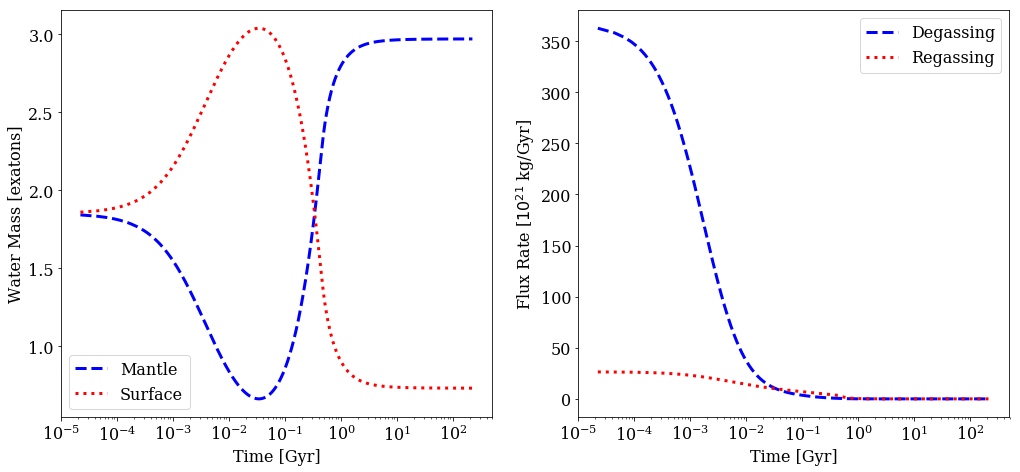

In [70]:
s_array_SS = omegatwid_array_SS - x_array_SS

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_SS*2.22, (x_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Mantle')
plt.semilogx(t_array_SS*2.22, (s_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Surface')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Water Mass [exatons]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_SS*2.22, (out_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_SS*2.22, (in_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_CA*2.87, (loss_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_CA_model_cycling_exploss.pdf', bbox_inches='tight')

In [71]:
s_array_SS = omegatwid_array_SS - x_array_SS

#print(out_array_SS[0], in_array_SS[0])
print(x_array_SS[-1])
print(s_array_SS[-1])
#print(x_array_SS[1], s_array_SS[1])
#print(T_array_SS[0])

1.6638702751139536
0.4097083202037721


In [72]:
tmp_time_array_SS = t_array_SS
tmp_temp_array_SS = T_array_SS
tmp_regas_array_SS = in_array_SS
tmp_degas_array_SS = out_array_SS
tmp_x_array_SS = x_array_SS
tmp_s_array_SS = s_array_SS

% store tmp_time_array_SS
% store tmp_temp_array_SS
% store tmp_regas_array_SS
% store tmp_degas_array_SS
% store tmp_x_array_SS
% store tmp_s_array_SS

Stored 'tmp_time_array_SS' (ndarray)
Stored 'tmp_temp_array_SS' (ndarray)
Stored 'tmp_regas_array_SS' (ndarray)
Stored 'tmp_degas_array_SS' (ndarray)
Stored 'tmp_x_array_SS' (ndarray)
Stored 'tmp_s_array_SS' (ndarray)


In [ ]:
## %matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_SS*2.22, T_array_SS*1600., color='purple')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)

In [ ]:
#tmp_time_array_SS = t_array_SS
#tmp_temp_array_SS = T_array_SS
#%store tmp_time_array_SS
#%store tmp_temp_array_SS

In [ ]:
#print(T_array_SS[-1]*1600.)

In [ ]:
#%matplotlib inline
# print M_E*omega_0*f_btwid*(omegatwid-x_array_SS[-1])
#earth ocean mass is 1.4e21
#print(omegatwid_array_SS[100000]*x_array_SS[100001]/omegatwid_array_SS[100001])
#print(x_array_SS[100001])
#plt.semilogx(x_array_SS)

### Hybrid model (degassing Kite, regassing S+S)

In [34]:
# Atmospheric loss ON/OFF -- now with a switch!

def f_omegatwid(x_twid, M, t):
    if atmos_loss == 0.:
        return omg_Etwid/(f_btwid)
    
    else:
        # Calculate mass of water in mantle, total mass of water
        M_w_mantle = x_twid * 2.3e-4 * 1.3 * M
        M_w_i = (omg_Etwid/f_btwid) * 2.3e-4 * 1.3 * M
    
        # Calculate water on surface, and remove a small amount.
        M_w_surf = (M_w_i - M_w_mantle) - 1e19*t #1e19*t is safe -- roughly 1 TO lost over simulations
    
        # Recalculate omega after some water has been lost, and omegatwid (which is the function output).
        M_w_f = M_w_surf + M_w_mantle
   
        return (M_w_f / M) / (2.3e-4 * 1.3)

In [35]:
D = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M #E in paper
def tau_5_inv(M):
    return Sigma(M)/D
def tau_5_inv_re(M):
    return Sigma(M)/Pi(M)
#print tau_5_inv(M_E)/(3.156e7*1.e9)
#print tau_5_inv_re(M_E)/(3.156e7*1.e9)
def Pitwid_2(M):
    return Pi(M)/D #D/E in paper

In [57]:
print(D/Pi(M_E))

0.28212665883132326


In [36]:
def Pi_2(M): #D2 in paper
    return h(M)**(1.-3.*beta)*(T_serp-T_s)/(T_ref**(1.+beta))*(kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*(np.exp(lnfugacity(1,T_ref)))))**(beta)
def Pi_2_1(t,temp,x,M): #D2_max*x_h*rho_c*chi_r in paper
    return x_h*rho_c*chi_r*(Rp(M)-(Rp(M)**3. - 3./4.*omega_0*f_btwid*M*(f_omegatwid(x,M,t)-x)/(math.pi*x_h*rho_m))**(1./3.))*np.exp(-beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(1.+beta)
Pi_c = 0.
def f_M_feed_hybrid(t,temp,x,M): 
    
    if cycling == 0.: #water cycling OFF
        return 0.
    
    else:
        if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
            return Pitwid_2(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(gtwid(M)**2.*(f_omegatwid(x,M,t)-x))**(-1.)
        elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
            return Pi_2_1(t,temp,x,M)/D*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(gtwid(M)**2.*(f_omegatwid(x,M,t)-x))**(-1.)
        if (f_omegatwid(x,M,t) - x) <= 0:
            return Pi_c/D*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1.,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x

In [ ]:
(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))
(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))

In [67]:
#print(D)
print(Pi_2_1(0.,2.,omegatwid/2.,M_E))
print(x_h, rho_c, chi_r, Rp(M_E), omega_0, f_btwid, M_E, rho_m)
print(beta, T_mtwid, T_stwid)

9493321.912944062
0.05 3000.0 0.03 6371000.0 0.00023 1.3 5.972e+24 3300.0
0.3 0.039708656716417906 0.175


In [37]:
def f_M_feed_hybrid_out(t,temp,x,M):
    
    if cycling == 0.: #water cycling OFF
        return 0.
    
    else:
        if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
            return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(gtwid(M)**2.*(f_omegatwid(x,M,t)-x))**(-1.)
        elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
            return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(gtwid(M)**2.*(f_omegatwid(x,M,t)-x))**(-1.)
        if (f_omegatwid(x,M,t) - x) <= 0:
            return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1.,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x

def f_M_feed_hybrid_in(t,temp,x,M):
    
    if cycling == 0.: #water cycling OFF
        return 0.
    
    else:
        if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
            return Pitwid_2(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) 
        elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
            return Pi_2_1(t,temp,x,M)/D*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) 
        if (f_omegatwid(x,M,t) - x) <= 0:
            return Pi_c/D*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))

In [59]:
print(f_M_feed_hybrid_in(0.,2.,omegatwid/2.,M_E))
print(f_M_feed_hybrid_out(0.,2.,omegatwid/2.,M_E))

104.10794424409885
2865.319373691541


In [38]:
def dhydr(temp,x,M):
    return Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1.,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta))

In [39]:
def dhydr_real(t,temp,x,M):
    if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
        return Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1.,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta))
    elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(f_omegatwid(x,M,t)-x) and (f_omegatwid(x,M,t) - x) > 0:
        return Pi_2_1(t,temp,x,M)/(x_h*rho_c*chi_r)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1.,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta))

In [40]:
def delta(temp,x,M):
    return h(M)*(Ra_c*eta_0*np.exp(1./T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)))**(-1)*kappa/(alpha*rho_m*g(M)*T_ref*(temp-T_stwid)*h(M)**3.))**(beta)

In [41]:
dhydr_a = []
delta_a = []
temp_a = []
temp = 0.5
while temp <= 2.5:
    dhydr_a.append(dhydr(temp,1,M_E))
    delta_a.append(delta(temp,1,M_E))
    temp_a.append(temp)
    temp = temp + 0.1
    

In [42]:
#semilogy(temp_a,np.divide(dhydr_a,1.e3),'k',temp_a,np.divide(delta_a,1.e3))
#dhydr always less than delta (unless T tiny, in which it becomes like the radius of the planet..), good!!

In [43]:
def f_all_wat_feed_hybrid(t,z,M):
    temp = z[0]
    x = z[1]
    return [tau_1_inv(M)/tau_2_inv(M)*f_conv_water(t,temp,x,M),tau_1_inv(M)/tau_5_inv(M)*f_M_feed_hybrid(t,temp,x,M)]


In [44]:
#x0_x,t0_x = 5.8e-4*0.68/(2.3e-4*1.3), 0.
omegatwid = omg_Etwid/(f_btwid)
x0_x,t0_x = omegatwid/2., 0.
sigma = 1.
mu = 1.
x0,t0 = 2., 0.
M = 1.*M_E
z0=[x0,x0_x]
#r = ode(f_fug,jac_fug).set_integrator('vode', with_jacobian=True)
r = ode(f_all_wat_feed_hybrid).set_integrator('vode')
#r.set_initial_value(z0, t0).set_f_params(gtwid,omegatwid,sigma,mu,M).set_jac_params(gtwid,omegatwid,sigma,mu,M)
r.set_initial_value(z0,t0).set_f_params(M)
t1 = 100.
dt = 1.e-5
t_array_hyb = np.zeros(int(t1/dt))
T_array_hyb = np.zeros(int(t1/dt))
x_array_hyb = np.zeros(int(t1/dt))
omegatwid_array_hyb = np.zeros(int(t1/dt))
in_array_hyb = np.zeros(int(t1/dt))
out_array_hyb = np.zeros(int(t1/dt))
d_hydr_hyb = np.zeros(int(t1/dt))
eta_array_hyb = np.zeros(int(t1/dt))
idx = 0
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_hyb[idx] = r.t
    T_array_hyb[idx] = r.y[0]
    x_array_hyb[idx] = r.y[1]
    omegatwid_array_hyb[idx] = f_omegatwid(r.y[1],M,r.t)
    in_array_hyb[idx] = f_M_feed_hybrid_in(r.t,r.y[0],r.y[1],M)
    out_array_hyb[idx] = f_M_feed_hybrid_out(r.t,r.y[0],r.y[1],M)
    d_hydr_hyb[idx] = dhydr_real(r.t,r.y[0],r.y[1],M)
    eta_array_hyb[idx] = eta(r.y[1], r.y[0])
    idx = idx + 1

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


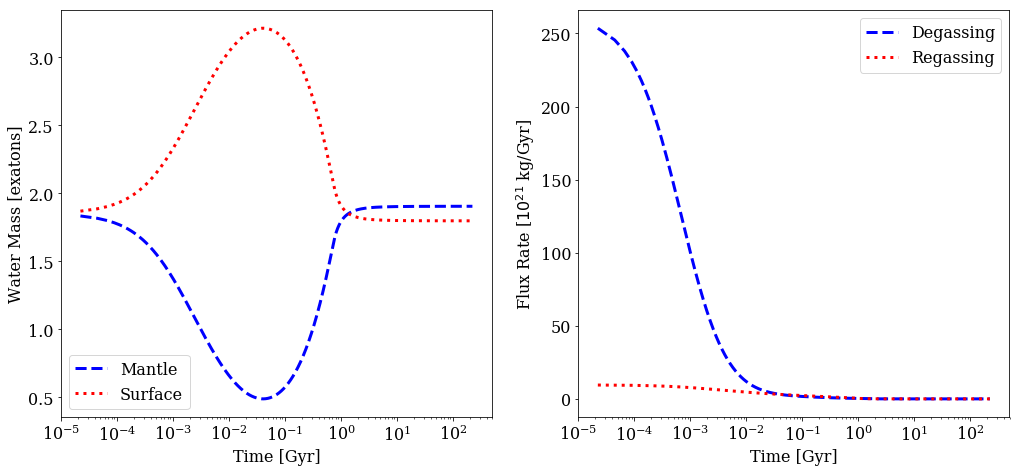

In [45]:
s_array_hyb = omegatwid_array_hyb - x_array_hyb

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_hyb*2.22, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Mantle')
plt.semilogx(t_array_hyb*2.22, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Surface')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Water Mass [$10^{21}$ kg/Gyr]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_hyb*2.22, (out_array_hyb*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb*2.22, (in_array_hyb*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_CA*2.87, (loss_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_CA_model_cycling_exploss.pdf', bbox_inches='tight')

In [51]:
tmp_time_array = t_array_hyb
tmp_temp_array = T_array_hyb
tmp_regas_array = in_array_hyb
tmp_degas_array = out_array_hyb
tmp_x_array = x_array_hyb
tmp_s_array = s_array_hyb

% store tmp_time_array
% store tmp_temp_array
% store tmp_regas_array
% store tmp_degas_array
% store tmp_x_array
% store tmp_s_array

Stored 'tmp_time_array' (ndarray)
Stored 'tmp_temp_array' (ndarray)
Stored 'tmp_regas_array' (ndarray)
Stored 'tmp_degas_array' (ndarray)
Stored 'tmp_x_array' (ndarray)
Stored 'tmp_s_array' (ndarray)


Text(0, 0.5, 'Mantle Temperature [K]')

<Figure size 1224x540 with 0 Axes>

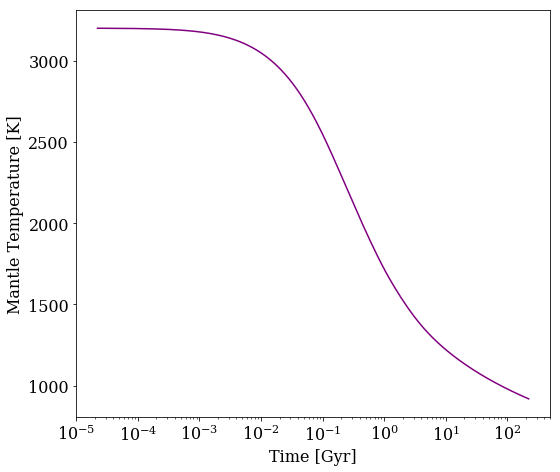

In [48]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_hyb*2.22, T_array_hyb*1600., color='purple')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)

### Compare different schemes

In [ ]:
# Atmospheric loss ON/OFF -- now with a switch!

def f_omegatwid(x_twid, M, t):
    
    if atmos_loss == 0.:
        return omg_Etwid/(f_btwid)
    
    else:
        # Calculate mass of water in mantle, total mass of water
        M_w_mantle = x_twid * 2.3e-4 * 1.3 * M
        M_w_i = (omg_Etwid/f_btwid) * 2.3e-4 * 1.3 * M
    
        # Calculate water on surface, and remove a small amount.
        M_w_surf = (M_w_i - M_w_mantle) - 1e19*t #1e19*t is safe -- roughly 1 TO lost over simulations
    
        # Recalculate omega after some water has been lost, and omegatwid (which is the function output).
        M_w_f = M_w_surf + M_w_mantle
   
        return (M_w_f / M) / (2.3e-4 * 1.3)

In [ ]:
#x_twid_array = x_array_CA
#
#test_omega = np.zeros(len(x_twid_array))
#test_M_w_mantle = np.zeros(len(x_twid_array))
#for idx in range(0, len(x_twid_array)):
#    test_M_w_mantle[idx] = x_twid_array[idx] * 2.3e-4 * 1.3 * M_E
#    M_w_i = (omg_Etwid/f_btwid) * 2.3e-4 * 1.3 * M_E
#    
#    M_w_surf = (M_w_i - test_M_w_mantle[idx]) - 1e13*idx
#    
#    M_w_f = M_w_surf + test_M_w_mantle[idx]
#    
#    test_omega[idx] = (M_w_f / M_E) / (2.3e-4 * 1.3)#

In [ ]:
#x = (omg_Etwid/f_btwid) * 2.3e-4 * 1.3 * M_E
#y = test_M_w_mantle[0]
#d = x - y
#print(d - 1e14*10e6)

In [ ]:
#CA, coupling to T from x (but no x from T)
mu = 1.
sigma = 1.
def f_M(t,x,gtwid,sigma,mu,M): #mantle water mass fraction rate of change with time
    
    if cycling == 0.: #water cycling OFF
        return 0. #no cycling after setting the initial mantle water mass fraction
    
    else:
        return (gtwid(M)**2.*(f_omegatwid(x,M,t)-x))**sigma - gamma*x*(gtwid(M)**2.*(f_omegatwid(x,M,t)-x))**(-mu)
    
def f_conv_water(t,temp,x,M): # change in temperature over heating timescale
    #add Q(t) but ignore and water effects for now
    return Q_0twid(M)*Qtwid(t,M) - ((np.exp(lnfugacity(x,temp))/np.exp(lnfugacity(1,T_ref)))**(beta)*(temp - T_stwid)**(beta+1.)*math.exp(-beta/T_mtwid*((1./temp) - 1.)))

def f_fug(t,z,gtwid,sigma,mu,M): #overall cycling equation -- NOTE degassing = regassing = 0 above
    #add Q(t) and water effects 
    temp = z[0]
    x = z[1]
    return [tau_1_inv(M)/tau_2_inv(M)*f_conv_water(t,temp,x,M),f_M(t,x,gtwid,sigma,mu,M)]

In [ ]:
def dhydr_CA(t,x,M):
    return d_hE*gtwid(M)**2.*(f_omegatwid(x,M,t)-x)**sigma

In [ ]:
#x0_x,t0_x = 5.8e-4*0.68/(2.3e-4*1.3), 0.
omegatwid = omg_Etwid/(f_btwid)
x0_x,t0_x = omegatwid/2., 0.
sigma = 1.
mu = 1.
x0,t0 = 2., 0.
M = 1.*M_E
z0=[x0,x0_x]
#r = ode(f_fug,jac_fug).set_integrator('vode', with_jacobian=True)
r = ode(f_fug).set_integrator('vode')
#r.set_initial_value(z0, t0).set_f_params(gtwid,omegatwid,sigma,mu,M).set_jac_params(gtwid,omegatwid,sigma,mu,M)
r.set_initial_value(z0,t0).set_f_params(gtwid,sigma,mu,M)
t1 = 100.
dt = 1.e-5
t_array_CA = np.zeros(int(t1/dt))
T_array_CA = np.zeros(int(t1/dt))
x_array_CA = np.zeros(int(t1/dt))
omegatwid_array_CA = np.zeros(int(t1/dt))
in_array_CA = np.zeros(int(t1/dt))
out_array_CA = np.zeros(int(t1/dt))
d_hydr_CA = np.zeros(int(t1/dt))
eta_array_CA = np.zeros(int(t1/dt))
idx = 0
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_CA[idx] = r.t
    T_array_CA[idx] = r.y[0]
    x_array_CA[idx] = r.y[1]
    omegatwid_array_CA[idx] = f_omegatwid(r.y[1],M,r.t)
    in_array_CA[idx] = (gtwid(M)**2.*(f_omegatwid(r.y[1],M,r.t))-r.y[1])**sigma
    out_array_CA[idx] = gamma*r.y[1]*(gtwid(M)**2.*(f_omegatwid(r.y[1],M,r.t))-r.y[1])**(-mu)
    d_hydr_CA[idx] = dhydr_CA(r.t,r.y[1],M)
    eta_array_CA[idx] = eta(r.y[1], r.y[0])
    idx = idx + 1
    #print(r.t, r.y)

In [ ]:
## %matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_CA*2.87, T_array_CA*1600., color='purple')
plt.ylim([800,3300])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)

In [ ]:
tmp_time_array = t_array_CA
tmp_temp_array = T_array_CA
%store tmp_time_array
%store tmp_temp_array

In [ ]:
print(T_array_CA[0]*1600., T_array_CA[-1]*1600.)

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(16,7.5))
plt.tight_layout()
ax = [fig.add_subplot(2,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

s_array_CA = np.multiply(gtwid(M_E),np.subtract(omegatwid_array_CA,x_array_CA))

kg_conv = 2.3e-4*1.3*M_E

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_CA*2.87, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Mantle')
plt.semilogx(t_array_CA*2.87, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Surface')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Water Mass [exatons]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# degassing: (kg_conv**2)/(9.8**2)...
# regassing: (kg_conv**2)/(9.8**2)

dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_CA*2.87, (out_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degas')
plt.semilogx(t_array_CA*2.87, (in_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regas')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Flux Rate [exatons/Gyr]', fontsize=16)
plt.legend(loc='lower right', fontsize=16)

In [ ]:
M_E = 5.972e24
R_E = 6.371e6
x_h = 0.05
rho_c = 3.e3
chi = 0.23
d_hE = 3e3
rho_m = 3.3e3
d_melt = 60.e3
f_degasE = 0.9
G = 6.67e-11
P_E = 4.e7
f_M = 0.68
f_b = 0.9
omega_0 = 2.3e-4
f_btwid = 1.3
year = 3.154e+7
omg_Etwid = 6.2e-4/2.3e-4

In [ ]:
def M_hydr(d_h):
    return 4./3.*math.pi*(R_E**3. - (R_E-d_h)**3.)*x_h*rho_m
i = 0
M_hydr_SS = []
M_hydr_CA = []
M_hydr_hyb = []
while i < len(t_array_SS):
    M_hydr_SS.append(M_hydr(d_hydr_SS[i]))
    M_hydr_hyb.append(M_hydr(d_hydr_hyb[i]))
    M_hydr_CA.append(M_hydr(d_hydr_CA[i]))
    i = i + 1
#M_hydr_twid = M_hydr/M_E
#print M_hydr_twid

In [ ]:
M_hydr = 4./3.*math.pi*(R_E**3. - (R_E-d_hydr_hyb[-1])**3.)*x_h*rho_c
M_hydr_twid = M_hydr/M_E
#print M_hydr_twid
#print omegatwid - x_array_hyb[-1]

In [ ]:
# Need a negative number check for the surface water depth.
# If they go negative, just set to zero -- planet is dessicated.
# XXX Should I be doing this check somewhere during the simulations? XXX

surface_array_SS = np.multiply(gtwid(M_E),np.subtract(omegatwid_array_SS,x_array_SS))
surface_array_hyb = np.multiply(gtwid(M_E),np.subtract(omegatwid_array_hyb,x_array_hyb))
surface_array_CA = np.multiply(gtwid(M_E),np.subtract(omegatwid_array_CA,x_array_CA))

# Now if it goes negative, set to 0. XXXX THIS CAN BE MADE MORE ROBUST LATER, WITH CHECKS FARTHER UP XXXX
surface_array_SS[surface_array_SS<0.] = 0.
surface_array_hyb[surface_array_hyb<0.] = 0.
surface_array_CA[surface_array_CA<0.] = 0.

In [ ]:
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
fig = plt.figure()
fig.set_size_inches(16,15)
ax1 = fig.add_subplot(221)
nlines = 3
colormap = plt.cm.gnuplot
ax1.set_color_cycle([colormap(i) for i in np.linspace(0., 0.85, nlines)])
ax1.semilogx(np.multiply(t_array_SS,tau_1_inv(M_E)/(3.156e7*1.e9)),T_array_SS,label=r'$\mathrm{T-dependent}$',linewidth=3)
ax1.semilogx(np.multiply(t_array_hyb,tau_1_inv(M_E)/(3.156e7*1.e9)),T_array_hyb,label=r'$\mathrm{hybrid}$',linewidth=3)
ax1.semilogx(np.multiply(t_array_CA,tau_1_inv(M_E)/(3.156e7*1.e9)),T_array_CA,label=r'$\mathrm{P-dependent}$',linewidth=3)

ax2 = fig.add_subplot(222)
ax2.axhline(1.3,linewidth=3,color='k',linestyle='--')
nlines = 3
colormap = plt.cm.gnuplot
ax2.set_color_cycle([colormap(i) for i in np.linspace(0., 0.85, nlines)])
ax2.semilogx(np.multiply(t_array_SS,tau_1_inv(M_E)/(3.156e7*1.e9)),x_array_SS,label=r'$\tilde{M} = 0.5$',linewidth=3)
ax2.semilogx(np.multiply(t_array_hyb,tau_1_inv(M_E)/(3.156e7*1.e9)),x_array_hyb,label=r'$\tilde{M} = 1$',linewidth=3)
ax2.semilogx(np.multiply(t_array_CA,tau_1_inv(M_E)/(3.156e7*1.e9)),x_array_CA,label=r'$\tilde{M} = 5$',linewidth=3)

ax3 = fig.add_subplot(223)
#ax3.axhline(0.75,linewidth=3,color='k',linestyle='--')
nlines = 3
colormap = plt.cm.gnuplot
ax3.set_color_cycle([colormap(i) for i in np.linspace(0., 0.85, nlines)])
ax3.semilogx(t_array_SS,surface_array_SS,label=r'$\mathrm{Surface} \ \mathrm{water}$',linewidth=3)
ax3.semilogx(t_array_hyb,surface_array_hyb,linewidth=3)
ax3.semilogx(t_array_CA,surface_array_CA,linewidth=3)
nlines = 3
colormap = plt.cm.gnuplot
ax3.set_color_cycle([colormap(i) for i in np.linspace(0., 0.85, nlines)])
ax3.semilogx(t_array_SS,np.multiply(M_hydr_SS,1./(omega_0*f_btwid*M_E)),linewidth=3,label=r'$\mathrm{Hydrated} \ \mathrm{layer}$',linestyle='--')
ax3.semilogx(t_array_hyb,np.multiply(M_hydr_hyb,1./(omega_0*f_btwid*M_E)),linewidth=3,linestyle='--')
ax3.semilogx(t_array_CA,np.multiply(M_hydr_CA,1./(omega_0*f_btwid*M_E)),linewidth=3,linestyle='--')

ax4 = fig.add_subplot(224)
#ax4.axhline(1.,linewidth=3,color='k',linestyle='--')
nlines = 3
colormap = plt.cm.gnuplot
ax4.set_color_cycle([colormap(i) for i in np.linspace(0., 0.85, nlines)])
ax4.loglog(t_array_SS,in_array_SS,label=r'$\mathrm{regassing}$',linewidth=3)
ax4.loglog(t_array_hyb,in_array_hyb,linewidth=3)
ax4.loglog(t_array_CA,in_array_CA,linewidth=3)
ax4.loglog(t_array_SS,out_array_SS,label=r'$\mathrm{degassing}$',linestyle='--',linewidth=3)
ax4.loglog(t_array_hyb,out_array_hyb,linestyle='--',linewidth=3)
ax4.loglog(t_array_CA,out_array_CA,linestyle='--',linewidth=3)

#ax3.axvline(1.,linewidth=3,color='k',linestyle='--')
#ax4.axvline(1.,linewidth=3,color='k',linestyle='--')

#ax1.legend(numpoints=1,ncol=1, loc=3, 
 #          borderaxespad=0.5,prop={'size':16})
ax4.set_xlabel(r'$\mathrm{Time} \ \tau$')
ax3.set_xlabel(r'$\mathrm{Time} \ \tau$')
ax1.set_xlabel(r'$\mathrm{Time} \ [\mathrm{Gyr}]$')
ax2.set_xlabel(r'$\mathrm{Time} \ [\mathrm{Gyr}]$')



ax4.set_ylabel(r'$\mathrm{Regassing} \ \mathrm{flux} \ \tilde{F}_{\downarrow}, \ \mathrm{Degassing} \ \mathrm{flux} \ \tilde{F}_{\uparrow}$')


ax2.set_ylabel(r'$\mathrm{Mantle} \ \mathrm{water} \ \mathrm{mass} \ \mathrm{fraction} \ \ \tilde{x}$')
ax3.set_ylabel(r'$\mathrm{Ocean} \ \mathrm{depth} \ \ \tilde{d}_{\mathrm{w}}, \ \mathrm{Hydrated} \ \mathrm{layer} \ \mathrm{water} \ \mathrm{fraction} \ \tilde{\omega}_{\mathrm{hyd}}}$')


ax1.legend(numpoints=1,ncol=1, loc=3, 
           borderaxespad=1.,prop={'size':18})
ax3.legend(numpoints=1,ncol=1, loc=3, bbox_to_anchor=(.05, 0.1), 
           borderaxespad=0.,prop={'size':18})
ax4.legend(numpoints=1,ncol=1, loc=3, 
           borderaxespad=1.,prop={'size':18})


#ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$\mathrm{Mantle} \ \mathrm{temperature} \ \ \tilde{T}$')
ax1.set_ylim(0.5,2.1)
ax1.set_xlim(1.e-5*tau_1_inv(M_E)/(3.156e7*1.e9),1.e2*tau_1_inv(M_E)/(3.156e7*1.e9))
ax2.set_xlim(1.e-5*tau_1_inv(M_E)/(3.156e7*1.e9),1.e2*tau_1_inv(M_E)/(3.156e7*1.e9))
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top') 
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom='off')
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom='off')
ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off')
ax4.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off')



#ax2.set_ylim(0.,omegatwid)
#ax1.get_xaxis().set_ticks([])
#ax2.get_xaxis().set_ticks([])
#ax3.get_xaxis().set_ticks([])
ax4.set_ylim(1.e-6,1.e4)




fig.tight_layout()

# Use this for the default water-cycling with atmospheric loss.
#savefig('comparison_xT_tau_waterdepth_4col.pdf',bbox_inches='tight')

# Use this for extreme water loss, i.e. definite desiccation.
savefig('comparison_xT_tau_waterdepth_4col_cycling_noloss.pdf',bbox_inches='tight')

In [ ]:
# Make some plots with physical units instead.
#Timescales are as follows, for tau=1:
#SS: 2.22 Gyr
#hyb: 2.22 Gyr
#CA: 2.87 Gyr
#Make some plots with physical units instead.
#Timescales are as follows, for tau=1:
#SS: 2.22 Gyr
#hyb: 2.22 Gyr
#CA: 2.87 Gyr
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(16,15))
plt.tight_layout()
ax = [fig.add_subplot(2,2,i+1) for i in range(4)]
fig.subplots_adjust(hspace=0)

# Mantle temperature T_ref = 1600 K. Multiply by T_ref (T_twid normalized to this value.)
ax = plt.subplot(2,2,1)
plt.semilogx(t_array_SS*2.22,T_array_SS*1600,label='T-dependent',linewidth=3,color='red',linestyle=':')
plt.semilogx(t_array_hyb*2.22,T_array_hyb*1600,label='hybrid',linewidth=3,color='purple',linestyle='-.')
plt.semilogx(t_array_CA*2.87,T_array_CA*1600,label='P-dependent',linewidth=3,color='blue',linestyle='--')
#plt.xlabel('Time [Gyr]', fontsize=16)
ax.set_xticklabels([])
plt.ylabel('Mantle Temperature [K]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Mantle viscosity (this should already be in its physical units based on the way I calculate it) -- [m^2/s]
# XXX Can normalize this to Earth for better understanding, or leave in these units XXX
ax = plt.subplot(2,2,2)
plt.semilogx(t_array_SS*2.22,eta_array_SS,label='T-dependent',linewidth=3,color='red',linestyle=':')
plt.semilogx(t_array_hyb*2.22,eta_array_hyb,label='hybrid',linewidth=3,color='purple',linestyle='-.')
plt.semilogx(t_array_CA*2.87,eta_array_CA,label='P-dependent',linewidth=3,color='blue',linestyle='--')
#plt.xlabel('Time [Gyr]', fontsize=16)
ax.set_xticklabels([])
ax.set_yscale('log')
plt.ylabel(r'Mantle Viscosity [$\rm{m}^2/\rm{s}$]',fontsize=16)

# Mantle water fraction of one Earth ocean at x_twid=1.32. XXX DOUBLE-CHECK THIS -- THIS IS WRONG XXX
ax = plt.subplot(2,2,3)
plt.semilogx(t_array_SS*2.22,x_array_SS/1.32,linewidth=3,label='T-dependent',color='red',linestyle=':')
plt.semilogx(t_array_hyb*2.22,x_array_hyb/1.32,linewidth=3,label='hybrid',color='purple',linestyle='-.')
plt.semilogx(t_array_CA*2.87,x_array_CA/1.32,linewidth=3,label='P-dependent',color='blue',linestyle='--')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Water Content [Earth Ocean Masses]', fontsize=16)
#plt.legend(loc='upper left', fontsize=16)

# Ocean depth of Earth taken as 4 km in paper.
ax = plt.subplot(2,2,4)
plt.semilogx(t_array_SS*2.22,surface_array_SS*4,linewidth=3,label='T-dependent',color='red',linestyle=':')
plt.semilogx(t_array_hyb*2.22,surface_array_hyb*4,linewidth=3,label='hybrid',color='purple',linestyle='-.')
plt.semilogx(t_array_CA*2.87,surface_array_CA*4,linewidth=3,label='P-dependent',color='blue',linestyle='--')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Ocean depth [km]',fontsize=16)
#plt.legend(loc='lower left',fontsize=16)

plt.savefig('Mantle_Surface_Water_Dimensions_Cycling_NoLoss.pdf', bbox_inches='tight') # Change name for different runs. runs.

In [ ]:
s_array_CA = omegatwid_array_CA - x_array_CA
s_array_SS = omegatwid_array_SS - x_array_SS
s_array_hyb = omegatwid_array_hyb - x_array_hyb

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,15))
plt.tight_layout()
ax = [fig.add_subplot(2,2,i+1) for i in range(4)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]

ax = plt.subplot(2,2,1)
plt.semilogx(t_array_CA*2.87, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='P-dependent')
plt.semilogx(t_array_hyb*2.22, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='purple', linestyle='-.', label='hybrid')
plt.semilogx(t_array_SS*2.22, (x_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='T-dependent')
plt.semilogx([1e-5, 287], [1.32*kg_conv/1000./1.0e18, 1.32*kg_conv/1000./1.0e18], color='k', linestyle='--', label='Earth Mantle Water')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Mantle Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='upper left', fontsize=15)

ax = plt.subplot(2,2,2)
plt.semilogx(t_array_CA*2.87, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='P-dependent')
plt.semilogx(t_array_hyb*2.22, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='purple', linestyle='-.', label='hybrid')
plt.semilogx(t_array_SS*2.22, (s_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='T-dependent')
plt.semilogx([1e-5, 287], [1.39, 1.39], color='k', linestyle='--', label='Earth Surface Water')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Surface Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=15)

dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]

ax = plt.subplot(2,2,3)
plt.loglog(t_array_CA*2.87, (out_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='P-dependent')
plt.loglog(t_array_hyb*2.22, (out_array_hyb*dr_conv*exa_gyr_conv), linewidth=3, color='purple', linestyle='-.', label='hybrid')
plt.loglog(t_array_SS*2.22, (out_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='T-dependent')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Degassing Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.ylim([1e-6, 1e3])
plt.legend(loc='upper right', fontsize=16)

plt.subplot(2,2,4)
plt.loglog(t_array_CA*2.87, (in_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='P-dependent')
plt.loglog(t_array_hyb*2.22, (in_array_hyb*dr_conv*exa_gyr_conv), linewidth=3, color='purple', linestyle='-.', label='hybrid')
plt.loglog(t_array_SS*2.22, (in_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='T-dependent')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Regassing Rate Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

plt.savefig('Presentation_allmodels_cycling_noloss_watercontent.pdf', bbox_inches='tight')


In [ ]:
# 1) TURN OFF ALL CYCLING & LOSS, AND SEE WHAT HAPPENS TO THE MANTLE TEMP (MAKE SURE IT IS COUPLED/SELF-CONSISTENT)
# 2) TEST EVEN MORE RAPID WATER LOSS/VERY SLOW WATER LOSS.
# 3) PLOT MANTLE VISCOSITY ALONG WITH MANTLE TEMPERATURE (POSSIBLY IN SAME SUBPLOT)

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]

ax = plt.subplot(1,2,1)
plt.loglog(t_array_CA*2.87, (out_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='P-dependent')
plt.loglog(t_array_hyb*2.22, (out_array_hyb*dr_conv*exa_gyr_conv), linewidth=3, color='purple', linestyle='-.', label='hybrid')
plt.loglog(t_array_SS*2.22, (out_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='T-dependent')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Degassing Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.ylim([1e-6, 1e3])
plt.legend(loc='upper right', fontsize=16)

plt.subplot(1,2,2)
plt.loglog(t_array_CA*2.87, (in_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='P-dependent')
plt.loglog(t_array_hyb*2.22, (in_array_hyb*dr_conv*exa_gyr_conv), linewidth=3, color='purple', linestyle='-.', label='hybrid')
plt.loglog(t_array_SS*2.22, (in_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='T-dependent')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Regassing Rate Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

plt.savefig('Presentation_allmodels_cycling_noloss_degas_regas.pdf', bbox_inches='tight')

In [ ]:
#print(np.shape(omegatwid), np.min(omegatwid), np.max(omegatwid))
#print(np.shape(x_array_hyb), np.min(x_array_hyb), np.max(x_array_hyb))
# Save these for easier plotting in the next cell.
#t_tau_hyb = np.multiply(t_array_hyb,tau_1_inv(M_E)/(3.156e7*1.e9))
#omega_x_hyb = np.subtract(omegatwid,x_array_hyb)
#print(omegatwid)
#print(r.t)

In [ ]:
%matplotlib inline

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.figure(figsize=(12,6))
plt.subplot(121)
#plt.semilogx(t_array_SS,np.multiply(gtwid(M_E),np.subtract(omegatwid,x_array_SS)),label=r'$\mathrm{Surface} \ \mathrm{water}$',linewidth=3, color='r')
#plt.semilogx(t_array_hyb,np.multiply(gtwid(M_E),np.subtract(omegatwid,x_array_hyb)),linewidth=3, color='k')
plt.semilogx(t_array_hyb,omega_x_hyb,linewidth=3, color='b')
#plt.semilogx(t_array_CA,np.multiply(gtwid(M_E),np.subtract(omegatwid,x_array_CA)),linewidth=3, color='b')
plt.xlabel(r'$\mathrm{Time} \ \tau$')
#plt.ylabel(r'$\mathrm{Ocean} \ \mathrm{depth} \ \ \tilde{d}_{\mathrm{w}}, \ \mathrm{Hydrated} \ \mathrm{layer} \ \mathrm{water} \ \mathrm{fraction} \ \tilde{\omega}_{\mathrm{hyd}}}$')
plt.ylabel(r'$\mathrm{Surface water mass fraction} \tilde{\omega} - \tilde{x}$')

plt.subplot(122)
plt.semilogx(t_tau_hyb,x_array_hyb,linewidth=3)
plt.xlabel(r'$\mathrm{Time} \ \tau$')
plt.ylabel(r'$\mathrm{Mantle water mass fraction} \tilde{x}$')
plt.savefig('SurfaceWater_and_MantleWater.png')

#plt.legend(numpoints=1,ncol=1, loc=3, bbox_to_anchor=(.05, 0.1), 
#           borderaxespad=0.,prop={'size':18})

In [ ]:
# Commented out r and r.set... lines commented back in, with the others commented out, to see what it outputs.

#x0_x,t0_x = 5.8e-4*0.68/(2.3e-4*1.3), 0.
omegatwid = omg_Etwid/(f_btwid)
x0_x,t0_x = omegatwid/2., 0.
sigma = 1.
mu = 1.
x0,t0 = 2., 0.
M = 1.*M_E
z0=[x0,x0_x]
#r = ode(f_fug).set_integrator('vode', with_jacobian=True)
r = ode(f_all_wat_feed_hybrid).set_integrator('vode')
#r.set_initial_value(z0, t0).set_f_params(gtwid,omegatwid,sigma,mu,M).set_jac_params(gtwid,omegatwid,sigma,mu,M)
r.set_initial_value(z0,t0).set_f_params(M)
t1 = 100.
dt = 1.e-5
t_array_hyb_new = np.zeros(int(t1/dt))
T_array_hyb_new = np.zeros(int(t1/dt))
x_array_hyb_new = np.zeros(int(t1/dt))
in_array_hyb_new = np.zeros(int(t1/dt))
out_array_hyb_new = np.zeros(int(t1/dt))
d_hydr_hyb_new = np.zeros(int(t1/dt))
idx = 0
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_hyb_new[idx] = r.t
    T_array_hyb_new[idx] =r.y[0]
    x_array_hyb_new[idx] = r.y[1]
    in_array_hyb_new[idx] = f_M_feed_hybrid_in(r.t,r.y[0],r.y[1],M)
    out_array_hyb_new[idx] = f_M_feed_hybrid_out(r.t,r.y[0],r.y[1],M)
    d_hydr_hyb_new[idx] = dhydr_real(r.y[0],r.y[1],M)
    idx = idx + 1
    
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogx(t_array_hyb_new[0::50], x_array_hyb_new[0::50], 'b')
plt.subplot(122)
plt.semilogx(t_array_hyb_new[0::50], np.subtract(omegatwid,x_array_hyb_new[0::50]), 'k')

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogx(t_array_hyb[0::100], x_array_hyb[0::100], 'b')
plt.subplot(122)
plt.semilogx(t_array_hyb[0::100], np.subtract(omegatwid,x_array_hyb[0::100]), 'k')

In [ ]:
# Try to have timesteps in log-time, equally spaced when plotted.
# Analytic way to estimate timestep/error? Estimate of what our time resolution needs to be. 
# --> Look into numerical methods to a priori determine the timestep.
# Fix integration loop to not append.

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogx(t_array_SS[0::100], x_array_SS[0::100], 'b')
plt.subplot(122)
plt.semilogx(t_array_SS[0::100], np.subtract(omegatwid,x_array_SS[0::100]), 'k')